### 1) Load Data

In [1]:
# https://github.com/pasqal-io/Pulser/blob/develop/tutorials/applications/QAOA%20and%20QAA%20to%20solve%20a%20QUBO%20problem.ipynb

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pulser import Pulse
from pulser import Sequence
from pulser import Register

from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform

from pulser_simulation import Simulation

from scipy.optimize import minimize
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

plt.style.use('dark_background')

In [3]:
# # Tutorial QUBO Matrix

# coupling_matrix = np.array(
#     [
#         [-10.0,      19.7365809,  19.7365809,  5.42015853, 5.42015853],
#         [19.7365809, -10.0,       20.67626392, 0.17675796, 0.85604541],
#         [19.7365809, 20.67626392, -10.0,       0.85604541, 0.17675796],
#         [5.42015853, 0.17675796,  0.85604541,  -10.0,      0.32306662],
#         [5.42015853, 0.85604541,  0.17675796,  0.32306662, -10.0     ],
#     ]
# )

In [4]:
# Load Peptide QUBO

QUBO_SIZE_LIMIT = 110
QUBO_SCALING_FACTOR = 1000

loaded_qubo = np.load('qubo_peptide.npy')

coupling_matrix = loaded_qubo[:QUBO_SIZE_LIMIT, 
                              :QUBO_SIZE_LIMIT] * QUBO_SCALING_FACTOR

In [5]:
MAX_TICK_COUNT = 10

np.random.seed(20)

coupling_matrix.shape, coupling_matrix.sum(), coupling_matrix.mean()

((110, 110), 68086.89, 5.6270156)

### 2) Embed to Atomic Register

In [6]:
def get_embedding_loss(coordinate_vector, coupling_matrix, shape):  
    
    coordinates = np.reshape(coordinate_vector, shape)
    
    pairwise_distances = pdist(coordinates)
    
    interaction_matrix = squareform(Chadoq2.interaction_coeff /  pairwise_distances ** 6)
    
    root_mean_square_error = np.linalg.norm(interaction_matrix - coupling_matrix)
    
    return root_mean_square_error

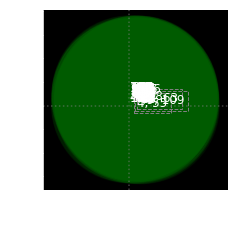

In [7]:
# Initial Coordinates

qubits_count = len(coupling_matrix)

coordinates_shape = (qubits_count, 2)

initial_coordinates = np.random.random(coordinates_shape)

coordinate_vector = initial_coordinates.flatten()

qubits_dict = dict(enumerate(initial_coordinates))

root_mean_square_errors = []    

atomic_register = Register(qubits_dict)

atomic_register.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1),
    draw_graph=False,
    draw_half_radius=True,
)

In [8]:
initial_root_mean_square_error = get_embedding_loss(coordinate_vector, coupling_matrix, coordinates_shape)

initial_root_mean_square_error

1.2411039339793542e+20

In [111]:
# Run Optimization Iteration

ITERATIONS_COUNT = 50
MINIMIZE_ITERATIONS = 10000
COORDINATES_TOLERANCE = 1e-6


for iteration in range(ITERATIONS_COUNT):
    
    # print("iteration:", iteration)

    optimal_coordinates_result = minimize(
        fun=get_embedding_loss,
        x0=coordinate_vector,
        args=(coupling_matrix, coordinates_shape),
        method="Nelder-Mead",
        tol=COORDINATES_TOLERANCE,
        options={"maxiter": MINIMIZE_ITERATIONS, "maxfev": None},
    )

    coordinate_vector = optimal_coordinates_result.x

    root_mean_square_error = get_embedding_loss(coordinate_vector, coupling_matrix, coordinates_shape)

    root_mean_square_errors.append(root_mean_square_error)
    
    print("root_mean_square_error:", root_mean_square_error)

optimal_coordinates = np.reshape(coordinate_vector, coordinates_shape)

root_mean_square_error: 15040.230869257708
root_mean_square_error: 15037.10280158582
root_mean_square_error: 15034.619623046048
root_mean_square_error: 15032.501588339825
root_mean_square_error: 15030.626839927692
root_mean_square_error: 15028.029597390645
root_mean_square_error: 15025.748020079385
root_mean_square_error: 15023.97709227214
root_mean_square_error: 15022.005232547648
root_mean_square_error: 15019.808072365371
root_mean_square_error: 15018.089523588691
root_mean_square_error: 15016.459157788724
root_mean_square_error: 15014.99887892512
root_mean_square_error: 15013.474916538304
root_mean_square_error: 15012.48617389901
root_mean_square_error: 15011.407908743522
root_mean_square_error: 15010.5066617721
root_mean_square_error: 15009.143399405157
root_mean_square_error: 15007.753189450299
root_mean_square_error: 15006.74838710249
root_mean_square_error: 15005.32959317637
root_mean_square_error: 15004.39676222921
root_mean_square_error: 15003.32517597781
root_mean_square_erro

In [112]:
len(root_mean_square_errors)

500

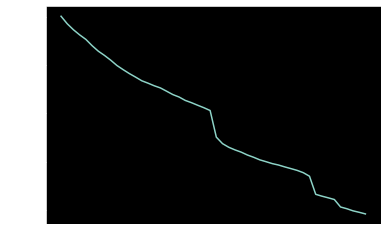

In [113]:
plt.plot(root_mean_square_errors[-50:]);

In [9]:
# optimal_coordinates = np.load('optimal_coordinates_110_500.npy')

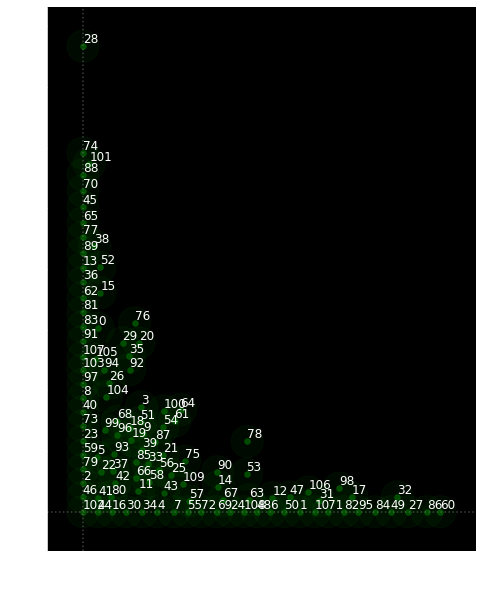

In [10]:
# Optimized Coordinates

qubits_dict = dict(enumerate(optimal_coordinates))

atomic_register = Register(qubits_dict)

atomic_register.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1),
    draw_graph=False,
    draw_half_radius=True,
)

In [11]:
# np.save('optimal_coordinates_110_550.npy', optimal_coordinates)

In [106]:
# Qubit Selection with radial mask

MAX_RADIAL_DISTANCE = 12


is_qubit_selected = np.linalg.norm(optimal_coordinates, axis=1) <= MAX_RADIAL_DISTANCE

selected_qubits = np.argwhere(is_qubit_selected).squeeze()

selected_qubits_count = len(selected_qubits)

selected_percent = selected_qubits_count / qubits_count * 100

selected_qubits_dict = {qubit: coordinates for qubit, coordinates in qubits_dict.items()
                        if qubit in selected_qubits}

selected_coupling_matrix = coupling_matrix[selected_qubits][:, selected_qubits]

print(f"Selected {selected_qubits_count} qubits, {selected_percent:.0f}%")

Selected 6 qubits, 5%


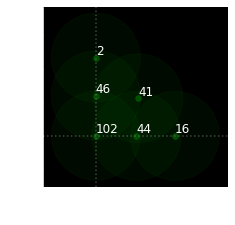

In [107]:
atomic_register = Register(selected_qubits_dict)

atomic_register.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1),
    draw_graph=False,
    draw_half_radius=True,
)

$$ H= \sum_{i=1}^N \frac{\hbar\Omega}{2} \sigma_i^x - \sum_{i=1}^N \frac{\hbar \delta}{2} \sigma_i^z+\sum_{j} ... $$

### 3) Quantum Adiabatic Algorithm (QAA)

In [108]:
def set_tick_count(tick_count):

    xtick_labels = plt.gca().get_xticklabels()

    tick_period = len(xtick_labels) // tick_count

    for label_index, label in enumerate(xtick_labels):

        if label_index % tick_period:

            label.set_visible(False)

In [109]:
# Modulation Parameters

DELTA_0 = -5
DELTA_F = -DELTA_0

DURATION = 4000
# DURATION = 10000
# DURATION = 40000

OMEGA_AMPLITUDE_LIMIT = 5


positive_coupling_coefficients = selected_coupling_matrix[selected_coupling_matrix > 0].flatten()

omega_amplitude = np.median(positive_coupling_coefficients)

omega_amplitude = min(OMEGA_AMPLITUDE_LIMIT, omega_amplitude)

omega_amplitude

5

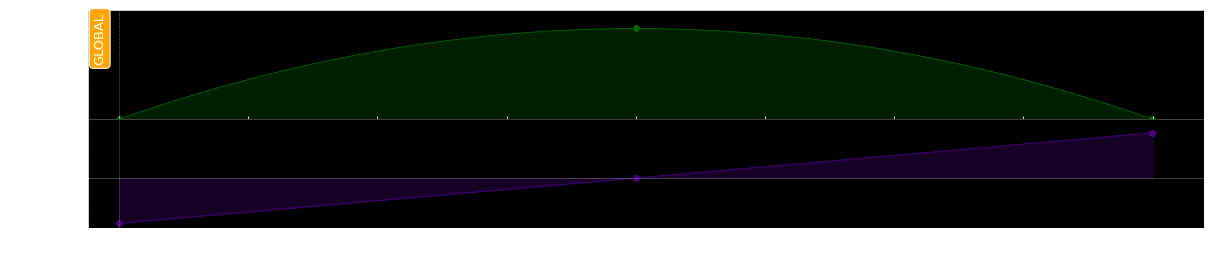

In [110]:
# Modulating Waveforms

amplitude_modulating_waveform = InterpolatedWaveform(DURATION, [1e-9, omega_amplitude, 1e-9])

frequency_modulating_waveform = InterpolatedWaveform(DURATION, [DELTA_0, 0, DELTA_F])

# Pulse

adiabatic_pulse = Pulse(
    amplitude=amplitude_modulating_waveform,
    detuning=frequency_modulating_waveform,
    phase=0,
)

# Sequence

sequence = Sequence(atomic_register, Chadoq2)
sequence.declare_channel("ising", "rydberg_global")
sequence.add(adiabatic_pulse, "ising")
sequence.draw()

In [111]:
# Run Simulation

SAMPLES_COUNT = 10000


simulation = Simulation(sequence=sequence)

results = simulation.run(progress_bar=True)

final_statevector = results.get_final_state()

counts = results.sample_final_state(N_samples=SAMPLES_COUNT)

# counts

10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.07s. Est. time left: 00:00:00:00
30.0%. Run time:   0.12s. Est. time left: 00:00:00:00
40.0%. Run time:   0.17s. Est. time left: 00:00:00:00
50.0%. Run time:   0.20s. Est. time left: 00:00:00:00
60.0%. Run time:   0.25s. Est. time left: 00:00:00:00
70.0%. Run time:   0.30s. Est. time left: 00:00:00:00
80.0%. Run time:   0.34s. Est. time left: 00:00:00:00
90.0%. Run time:   0.37s. Est. time left: 00:00:00:00
Total run time:   0.41s


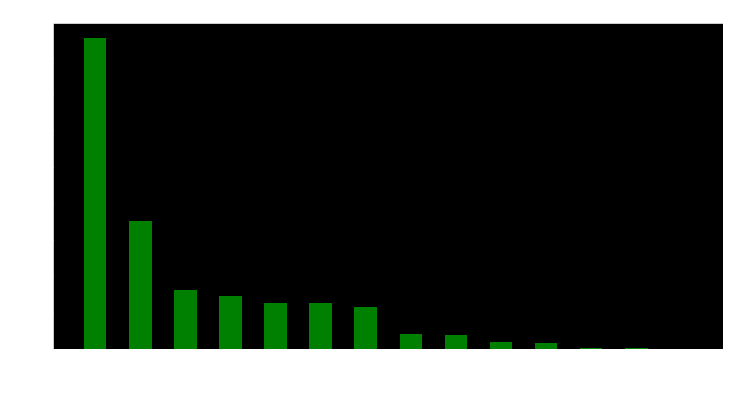

In [112]:
# Plot Histogram

tick_count = min(MAX_TICK_COUNT, len(counts))

descending_counts = dict(sorted(counts.items(), key=lambda item: -item[1]))   

plt.figure(figsize=(12, 6))
    
plt.bar(descending_counts.keys(), 
        descending_counts.values(), width=0.5, color="g")

set_tick_count(tick_count)

plt.xticks(rotation="vertical")

plt.title("Simulated counts")
plt.xlabel("State")
plt.ylabel("Count")
plt.show()

### 4) Top Samples and QUBO Energies

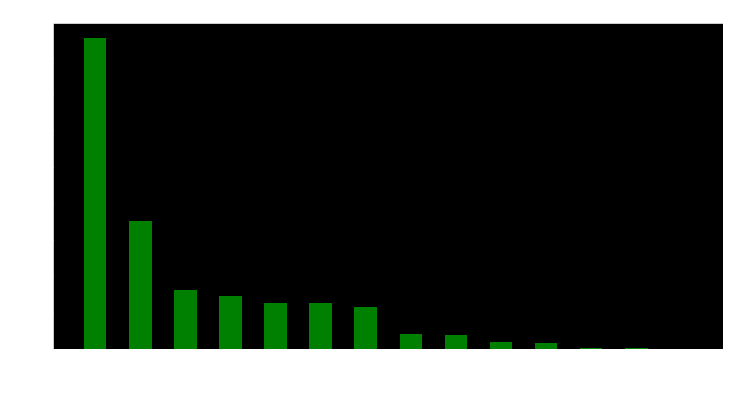

In [113]:
# Selected States

selected_states = np.array(list(descending_counts.keys()))

selected_state_strings = np.frombuffer(selected_states,'<U1')

selected_states_vector = selected_state_strings.astype('uint8')

selected_state_bits = selected_states_vector.reshape(-1, selected_qubits_count)

selected_state_bits.shape


# All States

state_indices = np.arange(2 ** selected_qubits_count)

binarize = np.vectorize(np.binary_repr)

state_strings = binarize(state_indices, selected_qubits_count)

state_indices_vector = state_indices.reshape(-1, 1).astype(np.uint8)

state_little_bits = np.unpackbits(state_indices_vector, 
                                  count=selected_qubits_count, 
                                  bitorder='little',
                                  axis=1)

all_state_bits = np.flip(state_little_bits, axis=1)

all_state_bits.shape


# Energies

energies = np.diag(selected_state_bits @ selected_coupling_matrix @ selected_state_bits.T)

energies_dict = dict(zip(selected_states, energies))

energies.shape


# Plot Counts

plt.figure(figsize=(12, 6))
    
plt.bar(descending_counts.keys(), 
        descending_counts.values(), width=0.5, color="g") 

set_tick_count(tick_count)

plt.xticks(rotation="vertical")

plt.title("Simulated counts")
plt.xlabel("State")
plt.ylabel("Count")
plt.show()

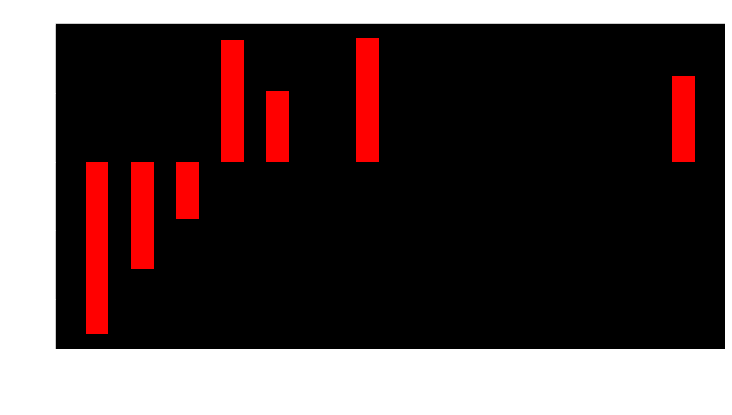

In [114]:
# Plot QUBO Energies

plt.figure(figsize=(12, 6))

plt.bar(energies_dict.keys(), 
        energies_dict.values(), width=0.5, color="r")

set_tick_count(tick_count)

plt.xticks(rotation="vertical")

plt.title("QUBO energies")
plt.xlabel("State")
plt.ylabel("Energy")
plt.show()

### 5) QUBO Energy per Pulse Duration

In [561]:
def get_state_energy(state, coupling_matrix):
    
    bits = np.array(list(state), dtype=int)
    
    energy = bits.T @ coupling_matrix @ bits
    
    return energy


def get_counts_energy(counts, coupling_matrix):
    
    energy_sum = sum(appearences_count * get_state_energy(state, coupling_matrix) 
                     for state, appearences_count in counts.items())
    
    samples_count = sum(counts.values())
    
    normalized_energy = energy_sum / samples_count
    
    return normalized_energy

In [542]:
MIN_DURATION = 500
MAX_DURATION = 20000
DURATION_STEP = 500
MINIMAL_DURATION_STEP = 4

duration_interval = (MAX_DURATION - MIN_DURATION) // DURATION_STEP + 1

durations = np.linspace(MIN_DURATION, MAX_DURATION, duration_interval)

# durations = durations // MINIMAL_DURATION_STEP * MINIMAL_DURATION_STEP

print("durations:", durations)

durations: [  500.  1000.  1500.  2000.  2500.  3000.  3500.  4000.  4500.  5000.
  5500.  6000.  6500.  7000.  7500.  8000.  8500.  9000.  9500. 10000.
 10500. 11000. 11500. 12000. 12500. 13000. 13500. 14000. 14500. 15000.
 15500. 16000. 16500. 17000. 17500. 18000. 18500. 19000. 19500. 20000.]


In [139]:
qubo_energy_sums = []

for duration in durations:
    
    print("duration:", duration)
    
    sequence = Sequence(atomic_register, Chadoq2)
    
    sequence.declare_channel("ising", "rydberg_global")
    
    amplitude_modulating_waveform = InterpolatedWaveform(duration, [1e-9, omega_amplitude, 1e-9])
    frequency_modulating_waveform = InterpolatedWaveform(duration, [DELTA_0, 0, DELTA_F])
        
    adiabatic_pulse = Pulse(
        amplitude=amplitude_modulating_waveform,
        detuning=frequency_modulating_waveform,
        phase=0,
    )
    
    sequence.add(adiabatic_pulse, "ising")
    
    simulation = Simulation(sequence)
    
    results = simulation.run()
    
    final_state = results.get_final_state()
    counts = results.sample_final_state()
    
    energy_sum = get_counts_energy(counts, selected_coupling_matrix) / 3
    
    qubo_energy_sums.append(energy_sum)

duration: 500.0
duration: 1000.0
duration: 1500.0
duration: 2000.0
duration: 2500.0
duration: 3000.0
duration: 3500.0
duration: 4000.0
duration: 4500.0
duration: 5000.0
duration: 5500.0
duration: 6000.0
duration: 6500.0
duration: 7000.0
duration: 7500.0
duration: 8000.0
duration: 8500.0
duration: 9000.0
duration: 9500.0
duration: 10000.0
duration: 10500.0
duration: 11000.0
duration: 11500.0
duration: 12000.0
duration: 12500.0
duration: 13000.0
duration: 13500.0
duration: 14000.0
duration: 14500.0
duration: 15000.0
duration: 15500.0
duration: 16000.0
duration: 16500.0
duration: 17000.0
duration: 17500.0
duration: 18000.0
duration: 18500.0
duration: 19000.0
duration: 19500.0
duration: 20000.0


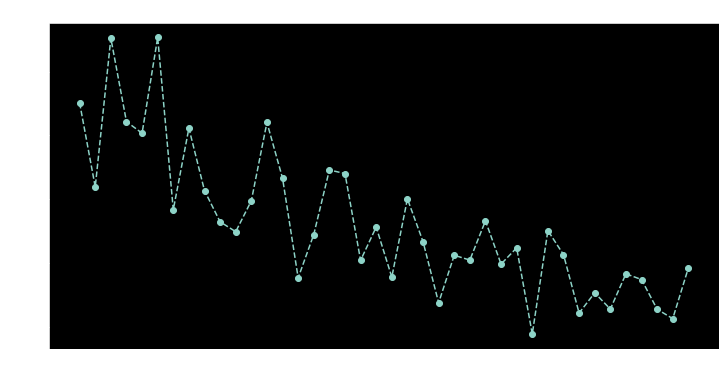

In [140]:
plt.figure(figsize=(12, 6))
plt.plot(durations, np.array(qubo_energy_sums), "--o")

plt.title("QUBO Energy per Pulse duration")
plt.xlabel("Pulse duration (µs)")
plt.ylabel("Energy")
plt.show()

In [66]:
# Alternative Energies

def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


energies_alt = np.array([get_cost_colouring(state, selected_coupling_matrix)
                         for state in selected_states])

np.allclose(energies, energies_alt)

True

### 6) Conclusions

In [ ]:
# We have used Quantum Adiabatic Algorithm (QAA) 
# to sample minimal energy states of imported Peptide QUBO

# One-cold Peptide QUBO coupling matrix size is 110 by 110 - requiring 110 qubits to run


# Some limitations observed:
    
    
# 1) Qubit counts

# 1.1) Simulator limitation - up to 100 qubits

# 1.2) Geometric limitation - up to 483 qubits:

# Atomic coordinates are limited by circle of 50 mkm radius
# Minimum distances between atoms are 4 mkm

# 1.3) Embedding - for our example 21 qubits (19% of 110) fit into above 50 mkm radius

# Atoms are arranged corresponding to Peptide QUBO coupling - not tightly packed


# 2) Execution time

# 2.1) Classical simulation time is about 60 seconds for 14 qubits and 4000 ns pulse duration,
#      exponentially depending on qubit count

# 2.2) Time of embedding QUBO to Atomic register is 20 minutes for 1M iterations of scipy minimise 
#      with Nelder–Mead method


# 3) Resulting Sampled states do not correspond to QUBO minimal energies